### Try infering a typical radious  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from bayes_coloc.continuous_donut_interaction import DonutInteraction
from bayes_coloc.plot_matching_lines import plot_pair_prob

import matplotlib.pyplot as plt
from skimage import io
import os
from matplotlib_scalebar.scalebar import ScaleBar
from multi_match.colorify import multichannel_to_rgb
import multi_match
import numpy as np
import matplotlib.pyplot as plt

from scipy.special import gammaln

%load_ext autoreload
%autoreload 2



In [2]:
# First we read some example images

file_A = os.path.join('data', 'channel_A_setting_3.tif')
file_B = os.path.join('data', 'channel_B_setting_3.tif')

l = 400
area = l**2
xlim_roi = [0, 0+l]
ylim_roi = [0, 0+l]
image_A = io.imread(file_A)
image_B = io.imread(file_B)


# We now can perform a point detection
x = multi_match.point_detection(image_A)
y = multi_match.point_detection(image_B)

data_file = os.path.join('data', 'true_params_setting_3.npy')
true_params = np.load(data_file, allow_pickle=True).item()
n_gamma = true_params['n_gamma']



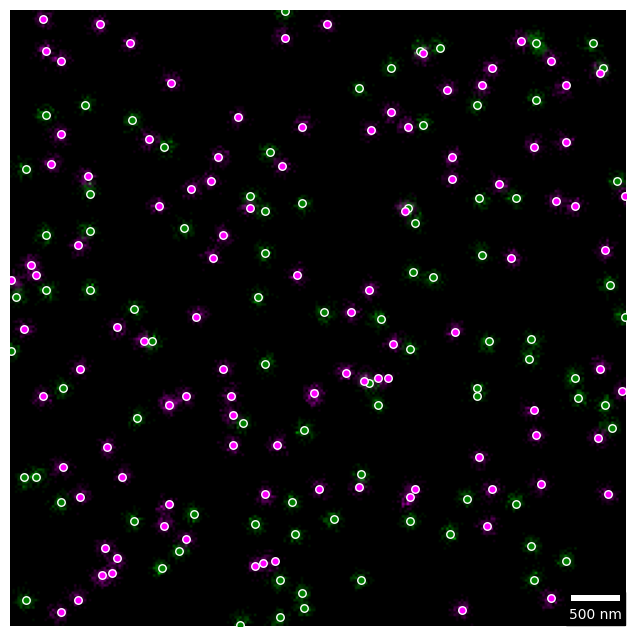

In [3]:
# and plot two channels of the data

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

background_image, _, __ = multichannel_to_rgb(images=[image_A, image_B], cmaps=['pure_green', 'pure_magenta'])
ax.imshow(background_image)
ax.axis("off")
ax.scatter(x[:, 0], x[:, 1], c="green", s=29, edgecolors="white", zorder=3)
ax.scatter(y[:, 0], y[:, 1], c="magenta", s=29, edgecolors="white", zorder=3)
# ax.set_xlim([100, 200])
# ax.set_ylim([100, 200])

# ax.scatter(z[:, 1], z[:, 0], c="cyan", s=4, edgecolors="white")
scalebar = ScaleBar(0.04,
        "nm",
        length_fraction=0.10,
        box_color="black",
        color="white",
        location="lower right")
scalebar.dx = 25
ax.add_artist(scalebar)


In [4]:
# define proposal, prior and starting parameters
scale_interval = [0, 6]
radius_interval = [0, 6]
area = image_A.shape[0]*image_A.shape[1]
hyper_theta = len(x)/2


    
def log_prior(params):
    """ Defines a log prior for the parameters of the model (up to a constant)"""
    
    lam_mu = params["lam_mu"]
    lam_gamma = params['lam_gamma']
    lam_nu = params["lam_nu"]
    radius = params['radius']
    scale = params['scale']
    
    # hyperparameters
    k = 1
    theta = hyper_theta
    def ld_gamma(x, k, theta):  
        a = k
        b = 1/theta
        if x <= 0:
            return -np.inf
        else:
            return a*np.log(b) - gammaln(a) + (a-1)*np.log(x) - b*x


    # check if lam parameters are valid
    log_prob = 0
    
    log_prob += ld_gamma(lam_mu, k, theta)
    log_prob += ld_gamma(lam_gamma, k, theta)
    log_prob += ld_gamma(lam_nu, k, theta)
    
    if scale_interval[0] < scale < scale_interval[1]:
        log_prob += 0
    else:
        log_prob = -np.inf
    if radius_interval[0] < radius < radius_interval[1]:
        log_prob += 0
    else:
        log_prob = -np.inf
    return log_prob

def proposal(params):
    """ Defines a proposal for the parameters of the model """
    scale_temp = 0.1
    radius_temp = 0.1
    intensity_temp = 2
    
    scale = params['scale']
    radius = params['radius']
    lam_mu = params["lam_mu"]
    lam_gamma = params['lam_gamma']
    lam_nu = params["lam_nu"]
    
    # new proposal for the scale
    scale_new = scale + np.random.normal(scale=scale_temp)
    new_radius = radius + np.random.normal(scale=radius_temp)
    
    # new proposal for the intensities
    lam_mu_new = lam_mu + np.random.normal(scale=intensity_temp)
    lam_nu_new = lam_nu + np.random.normal(scale=intensity_temp)
    lam_gamma_new = lam_gamma + np.random.normal(scale=intensity_temp)
    
    return {"lam_mu": lam_mu_new, "lam_nu": lam_nu_new, "lam_gamma": lam_gamma_new, "scale": scale_new, "radius":new_radius, "area":area}


start_params = {"lam_mu": hyper_theta, "lam_nu": hyper_theta, "lam_gamma": hyper_theta,
                "scale": 2, "radius":2, "area":area}
    


In [5]:
np.random.seed(3)
print(len(x), len(y))

chain = DonutInteraction(x, y, start_param=start_params, proposal=proposal, log_prior=log_prior)

87 105


In [6]:
chain.run(n_samples=50000, burn_in=0)
print(len(chain.param_trajectory))

Burn-in period: 0it [00:00, ?it/s]
Sampling:   0%|          | 0/50000 [00:00<?, ?it/s]

Sampling:   1%|          | 341/50000 [00:08<25:27, 32.51it/s]/home/nies1/pair-count/poisson_model/bayes_coloc/continuous_donut_interaction.py:90: RuntimeWarning: invalid value encountered in log
  lxy += ln(lam_gamma)
/home/nies1/serpe/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
Sampling:  11%|█         | 5571/50000 [02:05<13:35, 54.51it/s]/home/nies1/pair-count/poisson_model/bayes_coloc/new_proposal_mcmc.py:198: RuntimeWarning: divide by zero encountered in log
  log_acceptance_ratio += ln(reverse_swap_prob) -  ln(swap_prob)
Sampling:  23%|██▎       | 11411/50000 [04:06<07:00, 91.78it/s]/home/nies1/pair-count/poisson_model/bayes_coloc/continuous_donut_interaction.py:78: RuntimeWarning: invalid value encountered in log
  lxy -= ln(scale)
/home/nies1/pair-count/poisson_model/bayes_coloc/continuous_donut_interaction.py:161: RuntimeWarning: invalid value encountered in 

50001


In [7]:
chain.latent_acceptance_rate

0.02408

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


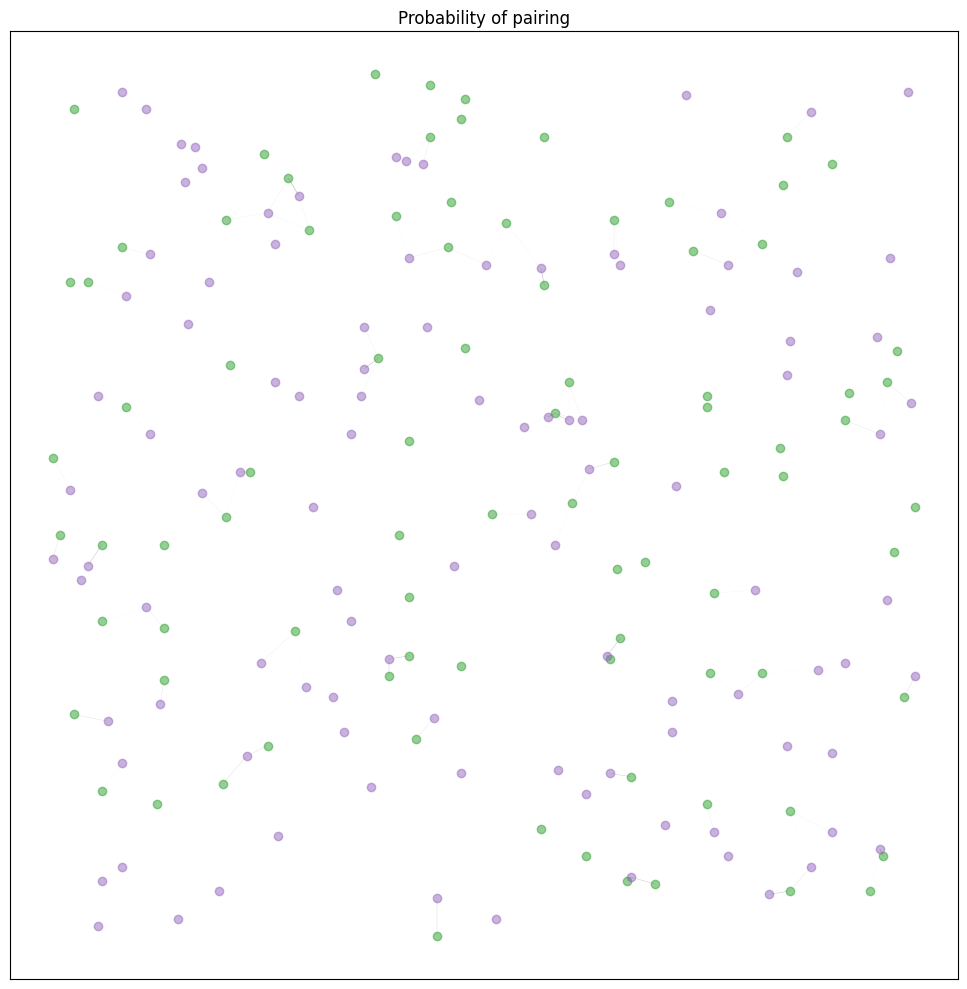

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
marker = "o"
alpha = 0.5
linewidth = 2

ax.set_aspect("equal")

# remove ticks
ax.set_xticks([])
ax.set_yticks([])
print(chain.pairing_probabilities())

plot_pair_prob(x, y, chain.pairing_probabilities(), ax=ax, l=linewidth, scatter_alpha=alpha)
ax.set_title("Probability of pairing")
# thight layout
plt.tight_layout()

plt.show()


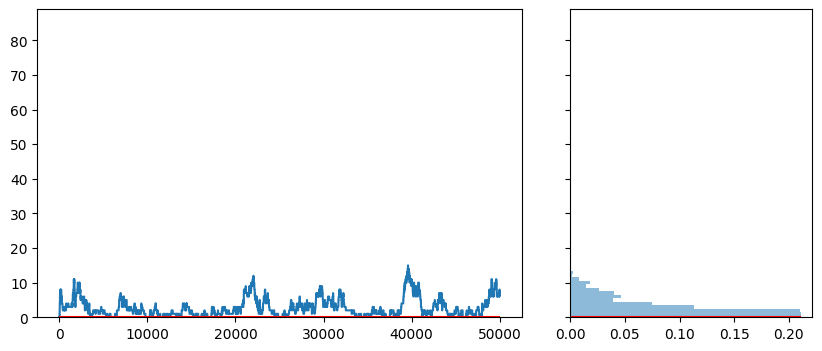

In [9]:
gridspec = dict(wspace=0.0, width_ratios=[1, 0.1, 0.5])
fig, ax = plt.subplots(nrows=1, ncols=3, gridspec_kw=gridspec, figsize=(10, 4))
nx = len(x)
ny = len(y)
n_max = np.minimum(nx, ny)


ax[1].set_visible(False)

pair_count = chain.pair_count_trajectory
ax[0].plot(np.arange(len(pair_count)), pair_count)
ax[0].set_ylim((0, n_max+2))
ax[0].hlines(y=n_gamma, xmin=0, xmax=len(pair_count), color="red")
bins = np.arange(n_max+2)-0.5
ax[2].hist(chain.pair_count_trajectory, bins=bins, alpha=0.5, label="MCMC", 
           orientation="horizontal", color="tab:blue", density=True)
xmax = np.max(np.histogram(pair_count, bins=bins, density=True)[0])
ax[2].hlines(y=n_gamma, xmin=0, xmax=xmax, color="red")
ax[2].set_ylim((0, n_max+2))
ax[2].set_yticklabels([])
plt.show()



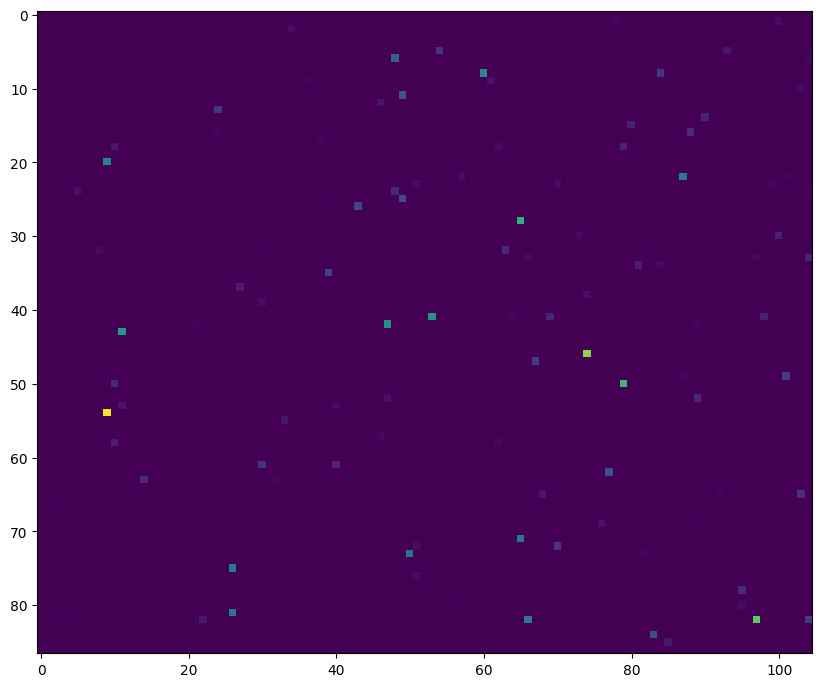

In [10]:
fig, ax = plt.subplots(ncols=1, figsize=(10, 10))
ax.imshow(chain.pairing_probabilities())

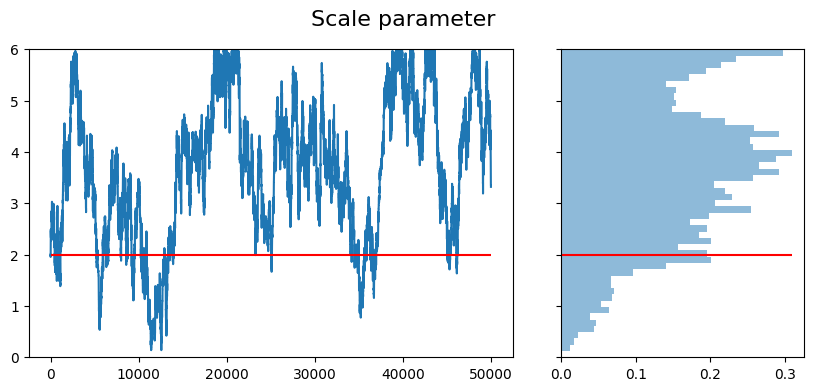

In [11]:
# scale parameter
gridspec = dict(wspace=0.0, width_ratios=[1, 0.1, 0.5])
fig, ax = plt.subplots(nrows=1, ncols=3, gridspec_kw=gridspec, figsize=(10, 4))
fig.suptitle("Scale parameter", fontsize=16)
ax[0].set_ylim(scale_interval)
ax[1].set_visible(False)

scale_trajectory = [params["scale"] for params in chain.param_trajectory]
ax[0].plot(np.arange(len(scale_trajectory)), scale_trajectory)
ax[0].hlines(y=true_params["scale"], xmin=0, xmax=len(scale_trajectory), color="red")

bins = np.linspace(scale_interval[0], scale_interval[1], 50)
ax[2].hist(scale_trajectory, bins=bins, alpha=0.5, label="MCMC", 
           color="tab:blue", density=True, orientation="horizontal")
xmax = np.max(np.histogram(scale_trajectory, bins=bins, density=True)[0])
ax[2].hlines(y=true_params["scale"], xmin=0, xmax=xmax, color="red")
ax[2].set_ylim(scale_interval)
ax[2].set_yticklabels([])
plt.show()



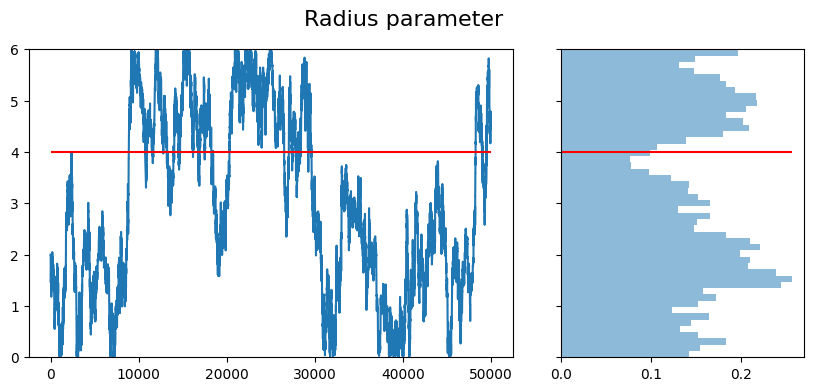

In [12]:
# do plot for radius parameter
gridspec = dict(wspace=0.0, width_ratios=[1, 0.1, 0.5])
fig, ax = plt.subplots(nrows=1, ncols=3, gridspec_kw=gridspec, figsize=(10, 4))
fig.suptitle("Radius parameter", fontsize=16)
ax[0].set_ylim(radius_interval)
ax[1].set_visible(False)

radius_trajectory = [params["radius"] for params in chain.param_trajectory]
ax[0].plot(np.arange(len(radius_trajectory)), radius_trajectory)
ax[0].hlines(y=true_params["radius"], xmin=0, xmax=len(radius_trajectory), color="red")

bins = np.linspace(radius_interval[0], radius_interval[1], 50)
ax[2].hist(radius_trajectory, bins=bins, alpha=0.5, label="MCMC", 
           color="tab:blue", density=True, orientation="horizontal")
xmax = np.max(np.histogram(radius_trajectory, bins=bins, density=True)[0])
ax[2].hlines(y=true_params["radius"], xmin=0, xmax=xmax, color="red")
ax[2].set_ylim(radius_interval)
ax[2].set_yticklabels([])
plt.show()


Text(0.5, 1.0, 'Trajectory in parameter space')

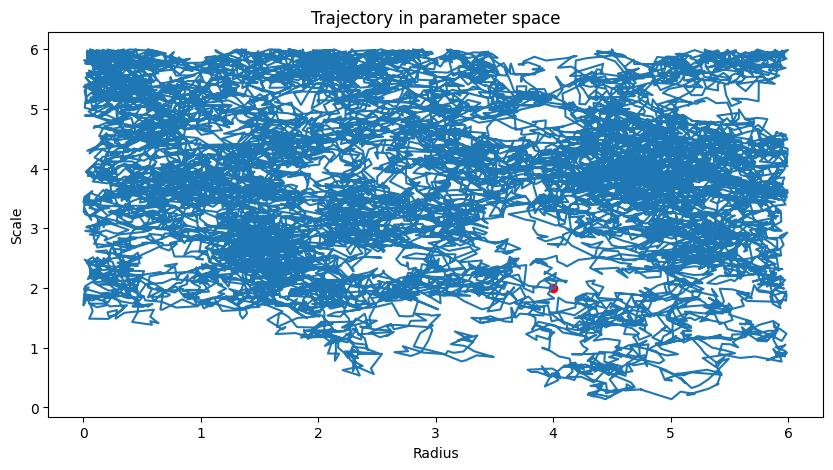

In [13]:
# plot trajectory of radius and scale in 2D
fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
ax.plot(radius_trajectory, scale_trajectory)
ax.scatter([true_params["radius"]], [true_params["scale"]], color="red")
ax.set_xlabel("Radius")
ax.set_ylabel("Scale")
ax.set_title("Trajectory in parameter space")



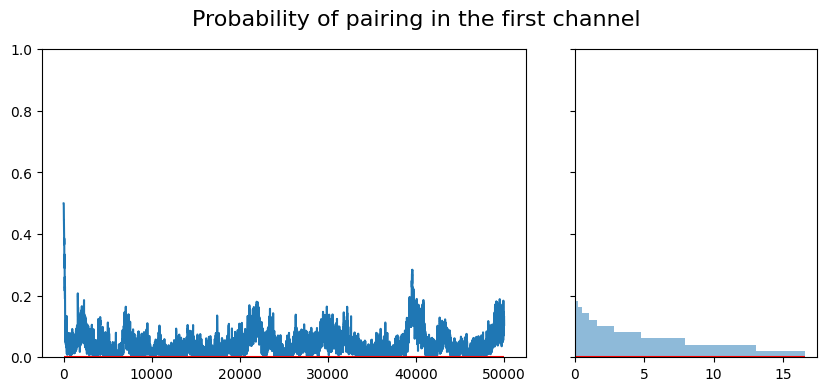

In [14]:
# Probability of A being paired with B
gridspec = dict(wspace=0.0, width_ratios=[1, 0.1, 0.5])
fig, ax = plt.subplots(nrows=1, ncols=3, gridspec_kw=gridspec, figsize=(10, 4))
fig.suptitle("Probability of pairing in the first channel", fontsize=16)
ax[0].set_ylim((0, 1))

ax[1].set_visible(False)
p_a_paired_traj = [params["lam_gamma"]/(params["lam_gamma"]+params["lam_mu"]) for params in chain.param_trajectory]
p_a_paired_true = true_params["lam_gamma"]/(true_params["lam_gamma"] + true_params["lam_mu"])
ax[0].plot(np.arange(len(p_a_paired_traj)), p_a_paired_traj)
ax[0].hlines(y=p_a_paired_true, xmin=0, xmax=len(p_a_paired_traj), color="red")

bins = np.linspace(0, 1, 50)
ax[2].hist(p_a_paired_traj, bins=bins, alpha=0.5, label="MCMC", 
           color="tab:blue", density=True, orientation="horizontal")
xmax = np.max(np.histogram(p_a_paired_traj, bins=bins, density=True)[0])
ax[2].hlines(y=p_a_paired_true, xmin=0, xmax=xmax, color="red")
ax[2].set_ylim((0, 1))
ax[2].set_yticklabels([])
plt.show()

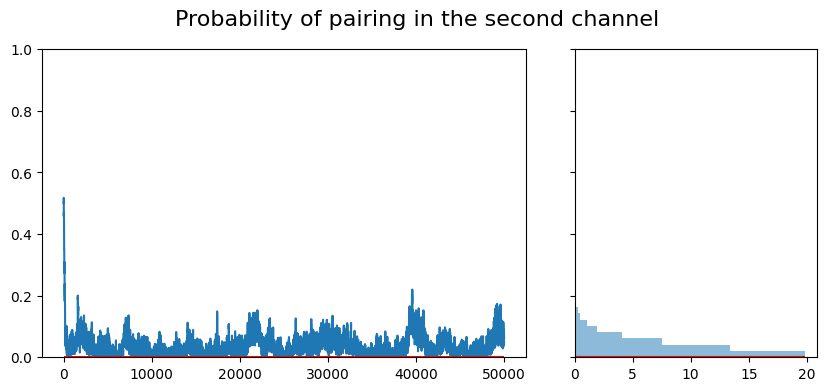

In [15]:
# probability of pairing in the second channel
gridspec = dict(wspace=0.0, width_ratios=[1, 0.1, 0.5])
fig, ax = plt.subplots(nrows=1, ncols=3, gridspec_kw=gridspec, figsize=(10, 4))
fig.suptitle("Probability of pairing in the second channel", fontsize=16)
ax[0].set_ylim((0, 1))

ax[1].set_visible(False)
p_b_pair_traj = [params["lam_gamma"]/(params["lam_gamma"]+params["lam_nu"]) for params in chain.param_trajectory]
p_b_pair_true = true_params["lam_gamma"]/(true_params["lam_gamma"] + true_params["lam_nu"])
ax[0].plot(np.arange(len(p_b_pair_traj)), p_b_pair_traj)
ax[0].hlines(y=p_b_pair_true, xmin=0, xmax=len(p_b_pair_traj), color="red")

bins = np.linspace(0, 1, 50)
ax[2].hist(p_b_pair_traj, bins=bins, alpha=0.5, label="MCMC", 
           color="tab:blue", density=True, orientation="horizontal")
xmax = np.max(np.histogram(p_b_pair_traj, bins=bins, density=True)[0])
ax[2].hlines(y=p_b_pair_true, xmin=0, xmax=xmax, color="red")
ax[2].set_ylim((0, 1))

ax[2].set_yticklabels([])
plt.show()



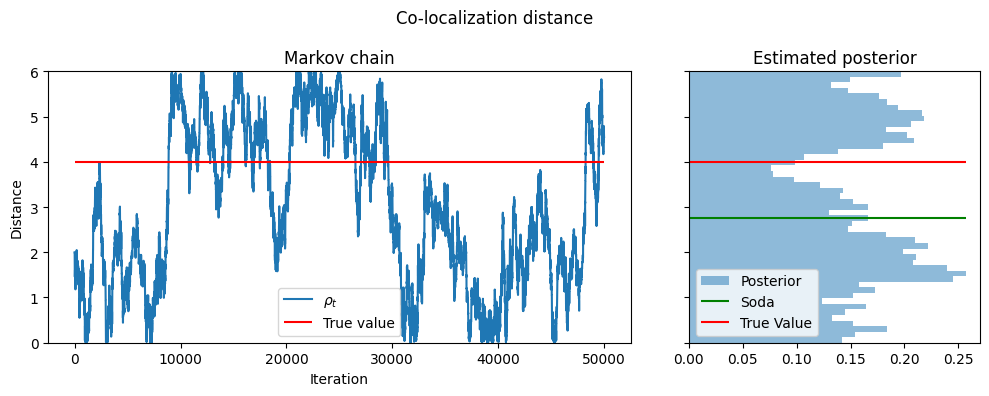

In [22]:
# do plot for radius parameter
ripley_dist = 0
soda_dist = 2.76
gridspec = dict(wspace=0.0, width_ratios=[1, 0.1, 0.5])
fig, ax = plt.subplots(nrows=1, ncols=3, gridspec_kw=gridspec, figsize=(10, 4))
fig.suptitle("Co-localization distance")# , fontsize=16)
ax[0].set_ylim(radius_interval)
ax[1].set_visible(False)

radius_trajectory = [params["radius"] for params in chain.param_trajectory]
ax[0].plot(np.arange(len(radius_trajectory)), radius_trajectory, label=r'$\rho_t$')
ax[0].set_xlabel("Iteration")
ax[0].set
ax[0].set_ylabel("Distance")
ax[0].hlines(y=true_params["radius"], xmin=0, xmax=len(radius_trajectory), color="red", label="True value")
# ax[0].hlines(y=ripley_val_radius, xmin=0, xmax=len(radius_trajectory), color="red", label="Ripley value")
ax[0].legend()
ax[0].set_title("Markov chain")

bins = np.linspace(radius_interval[0], radius_interval[1], 50)
ax[2].set_title("Estimated posterior")
ax[2].hist(radius_trajectory, bins=bins, alpha=0.5, label="Posterior", 
           color="tab:blue", density=True, orientation="horizontal")
xmax = np.max(np.histogram(radius_trajectory, bins=bins, density=True)[0])
ax[2].hlines(y=soda_dist, xmin=0, xmax=xmax, color="green", label="Soda")
ax[2].hlines(y=true_params["radius"], xmin=0, xmax=xmax, color="red", label="True Value")
ax[2].set_ylim(radius_interval)
ax[2].set_yticklabels([])
ax[2].legend(loc="lower left")
plt.tight_layout()
plt.savefig("plots/setting_3_rho.png", dpi=400)
plt.show()


In [17]:
from scipy.special import iv

            
def log_noncentral_chi_pdf(x, df, nc):
    """
    This function takes an input array-like object x, degrees of freedom df,
    and non-centrality parameter nc, and returns the log of the pdf of the
    noncentral chi-distribution evaluated at x.
    """
    output = (-x**2/2 - nc**2/2) + np.log(x)*(df-df/2) + (1-df/2)*np.log(nc) + np.log(iv(df/2 - 1, x*nc))
    # if some of the output values are nans replace them with -inf
    np.nan_to_num(output, copy=False, nan=-np.inf)
    return output

In [19]:
def den(x, df, nc):
    return np.exp(log_noncentral_chi_pdf(x, df, nc))


0.9999999999999761


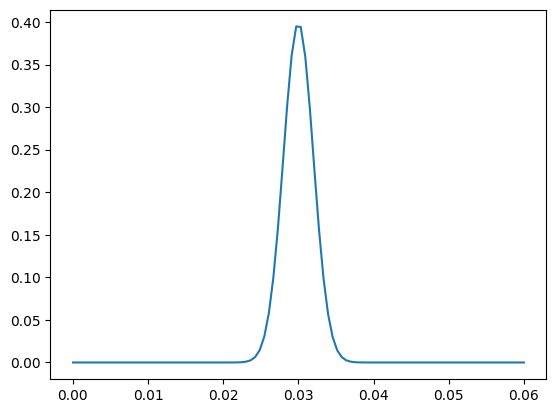

In [20]:
# plot density of den
radius = 0.03
sigma = 0.002
x = np.linspace(0.01, radius/sigma*2, 100)
nc = (radius/sigma)**1
df = 1
y = den(x, df, nc)
plt.plot(x*sigma, y)

print(np.sum(y)*(x[1]-x[0]))



In [21]:
def ln_gamma(x, y, params):
    """ Logarithm of joint intensity function"""
    # get parameters
    lam_gamma = params['lam_gamma']
    scale = params['scale']
    radius = params['radius']
    area = params['area']

    # compute log of joint intensity
    d_sq = np.sum((x-y)**2, axis=-1)
    dist = np.sqrt(d_sq)
    nc = radius/scale
    df = 2
        
    # distributes as non central chi                                                       
    v = dist/scale

    # compute log of non central chi squared
    lxy = log_noncentral_chi_pdf(v, df, nc)
        
    # random direction 
    lxy -= np.log(2*np.pi) 
    # for general case: 
    # lxy -= np.log(np.pi**(df/2)/np.math.factorial(int(df/2+1)))
        
    # account for change of variables to polar in 2d
    lxy -= np.log(scale) 
    lxy -= np.log(dist)
    # remove nans
    lxy = np.nan_to_num(lxy, copy=False, nan=-np.inf)
    return lxy

# plot this function for x = [0, 0] and different ys in R^2
x = np.array([0, 0])    
y = np.array([0, 2])
params = true_params
def f(y, params):
    x = np.array([0, 0])
    return np.exp(ln_gamma(x, y, params))
print(ln_gamma(x, y, params))

-4.129691941333369


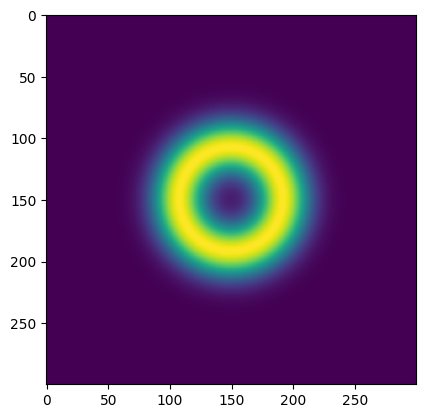

In [22]:
l = 10
y0 = np.linspace(-l, l, 300)
y1 = np.linspace(-l, l, 300)
Y0, Y1 = np.meshgrid(y0, y1)
Z = np.zeros_like(Y0)
for i in range(len(y0)):
    for j in range(len(y1)):
        y = np.array([y0[i], y1[j]])
        Z[i, j] = f(y, params)
plt.imshow(Z.T)

In [23]:
# check if area sums up to 1
print(np.sum(Z)*(y0[1]-y0[0])*(y1[1]-y1[0]))

0.9999999999996823


Text(0.5, 1.0, 'Trajectory of intensity parameter')

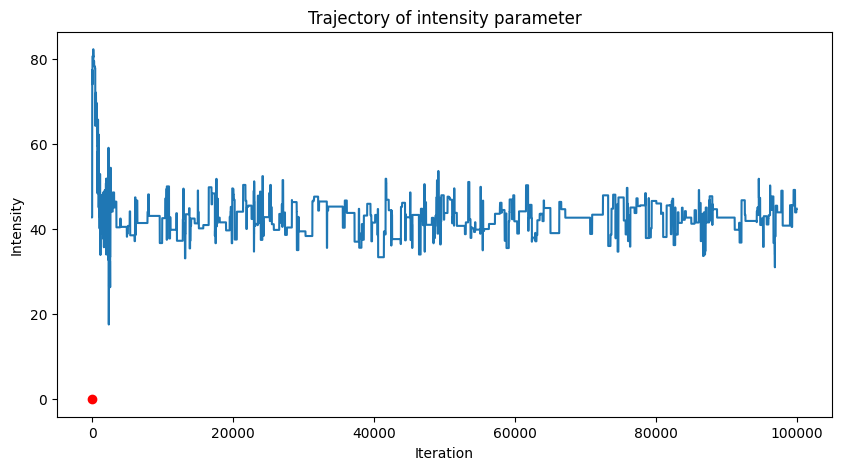

In [24]:
# plot trajectory lam_nu
trajectory_lam_mu = [params["lam_mu"] for params in chain.param_trajectory]

# plot trajectory 
fig, ax = plt.subplots(ncols=1, figsize=(10, 5))
ax.plot(np.arange(len(trajectory_lam_mu)), trajectory_lam_mu)
ax.scatter([true_params["lam_mu"]], [true_params["lam_mu"]], color="red")
ax.set_xlabel("Iteration")
ax.set_ylabel("Intensity")
ax.set_title("Trajectory of intensity parameter")

